In [1]:
%pip install shapely

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import os
import pandas as pd1
import pandas as pd2
import pandas as pd3
import numpy as np
import seaborn as sns; sns.set()

#mapbox
import json
import plotly.graph_objects as go 
import plotly.express as px
from shapely.geometry import shape

In [3]:
dfsf2014 = pd1.read_csv('sanfrancisco_incidents_summer_2014.csv')#, index_col='IncidntNum')
dfsf2014['hour_start'] = pd1.DatetimeIndex(dfsf2014['Time']).hour
dfsf2014['Month'] = pd1.DatetimeIndex(dfsf2014['Date']).month
dfsf2014['Year'] = pd1.DatetimeIndex(dfsf2014['Date']).year

In [4]:
#####################SEATTLE
dfsea2014 = pd2.read_csv('seattle_incidents_summer_2014.csv',low_memory=False)
dfsea2014['Report Number1'] = dfsea2014['General Offense Number'].astype('string').str.slice(start=0, stop=4)+'-'+dfsea2014['General Offense Number'].astype('string').str.slice(start=4)

dfsea2014['hour_start'] = pd2.DatetimeIndex(dfsea2014['Occurred Date or Date Range Start']).hour
dfsea2014['date_start'] = pd2.to_datetime(dfsea2014["Occurred Date or Date Range Start"]).dt.date

#ZoneHour: Clasificar hora del dia. Mañana: de 6 a 12, Tarde: de 12 a 19 ,Noche: de 19 a 24 y Madrugada de 24 a 6.
dfsea2014['ZoneHour'] = 'Unknown'
dfsea2014.loc[(dfsea2014['hour_start']>5) & (dfsea2014['hour_start']<12), 'ZoneHour'] = 'tomorrow'
dfsea2014.loc[(dfsea2014['hour_start']>11) & (dfsea2014['hour_start']<19), 'ZoneHour'] = 'late'
dfsea2014.loc[(dfsea2014['hour_start']>18) & (dfsea2014['hour_start']<24), 'ZoneHour'] = 'night'
dfsea2014.loc[(dfsea2014['hour_start']>-1) & (dfsea2014['hour_start']<6), 'ZoneHour'] = 'early morning'
#hour_starthhmm, extrae hora y genera formato hh:mm
dfsea2014['hour_starthhmm'] = pd2.DatetimeIndex(dfsea2014['Occurred Date or Date Range Start']).strftime("%H:00")

#dfsea2014_all. Carga de archivo CSV seattle_line_full_data_2014-2015.csv
dfsea2014_all = pd2.read_csv('seattle_line_full_data_2014-2015.csv',low_memory=False,usecols=['Year of Offense Start DateTime','Latitude','Longitude','Report Number','Month of Offense Start DateTime','MCPP','Offense','Precinct','SeaStat Category ','SeaStat Offense','Neighborho','PCT','PCT Full','Sector','Crime Against Category'])
#Elimina Registros duplicados con key 'Report Number','SeaStat Category ','SeaStat Offense'
dfsea2014_all.drop_duplicates(['Report Number','SeaStat Category ','SeaStat Offense'], inplace=True)

#dfsea2014. Merge entre los dos CSV a traves de columna Report Number 1 y Report Number.
#Se agrega a dfsea2014 columnas de CSV seattle_line_full_data_2014-2015.csv :
#'Report Number','Month of Offense Start DateTime','MCPP','Offense','Precint','SeaStat Category','SeaStat Offense','Neigborho','PCT','PCT Full','Sector','Crime Against Category'
dfsea2014=dfsea2014.merge(dfsea2014_all, left_on='Report Number1', right_on='Report Number', how='left')


In [5]:
#Declaraciones Comunes

def formato_hora(x, pos):
    return '{0}:00'.format(int(x))

def formato_numerico(x, pos):
    return "{:,}".format(int(x)).replace(',','~').replace('.',',').replace('~','.')
    #return '{:,}'.format(int(x))

legend_prop_bold = {'weight':'bold'}

1. ¿Cómo varían los incidentes según la hora del día?


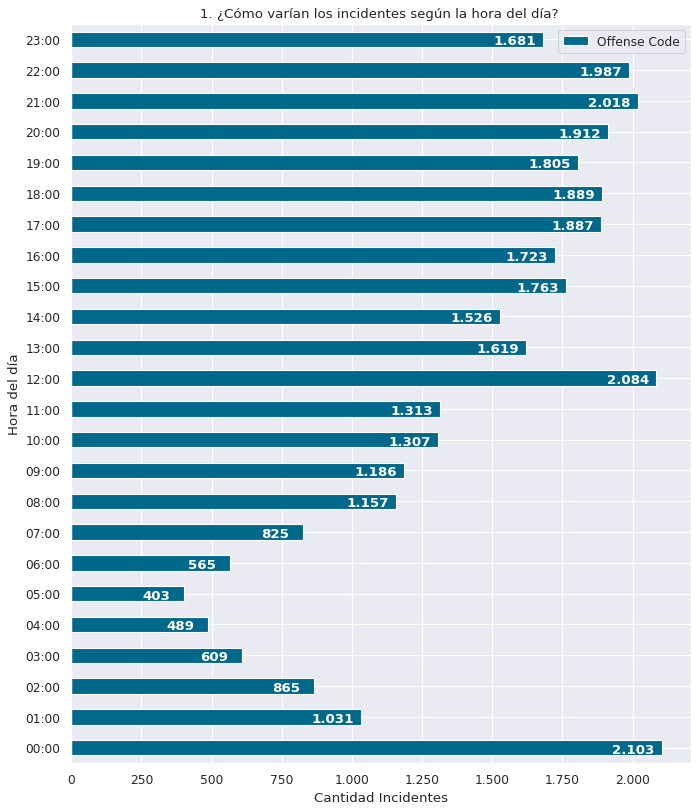

In [6]:
#SEATTLE
# 1 ¿cómo varían los incidentes según la hora del día? 
print('1. ¿Cómo varían los incidentes según la hora del día?')

#by_hour. Agrupar con pivot_table por hora. cantidad con Offense Code.
by_hour = dfsea2014.pivot_table('Offense Code', aggfunc='count',index='hour_starthhmm')
by_hour.sort_values(["hour_starthhmm"], ascending= [True], inplace=True)

 
fig, ax = plt.subplots(figsize=(10,12), dpi=80)
ax.xaxis.set_major_formatter(FuncFormatter(formato_numerico))
by_hour.plot.barh(ax=ax,color='#00688B',ylabel='Hora del día',xlabel='Cantidad Incidentes',rot=0,title='1. ¿Cómo varían los incidentes según la hora del día? ')
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    # The height of the bar is the data value and can be used as the label
    label_text = "{:,}".format(int(width)).replace(',','~').replace('.',',').replace('~','.')
    label_x = x + width - 100
    label_y = y + ((height / 2)-0.05)
    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x,label_y,label_text,ha='center',va='center',color='w',fontsize=12,weight='bold')

2.1 ¿Qué incidentes son más comunes por la noche?
2.2 ¿En qué periodos del día son más comunes los robos?


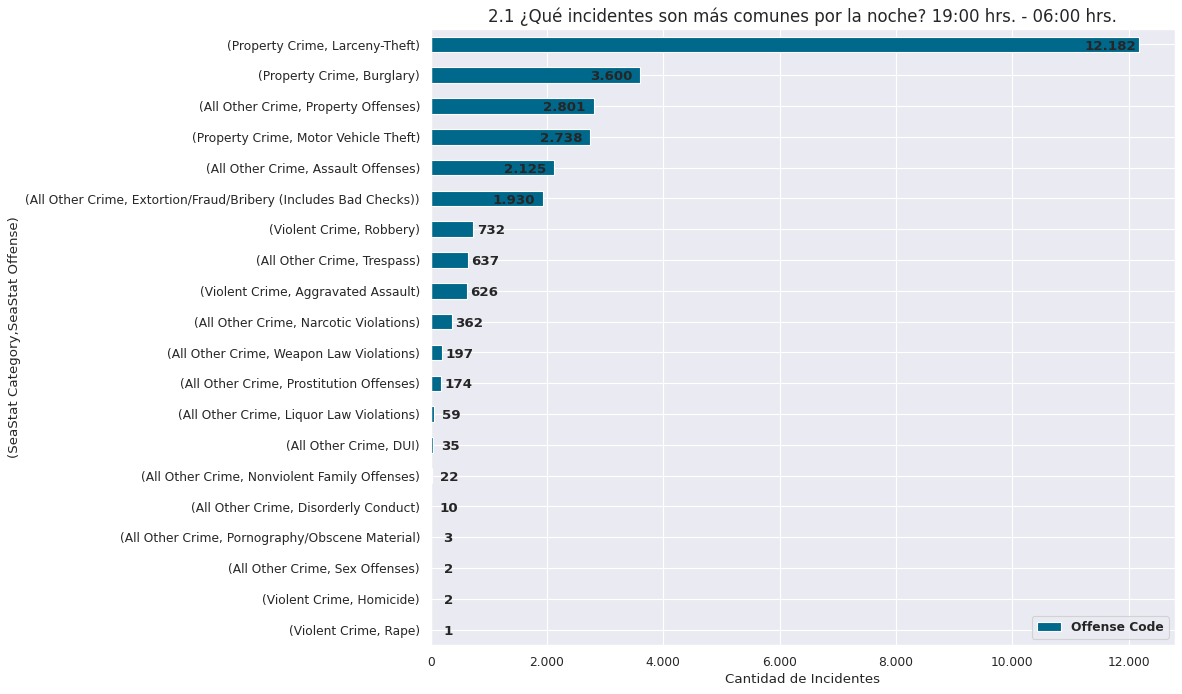

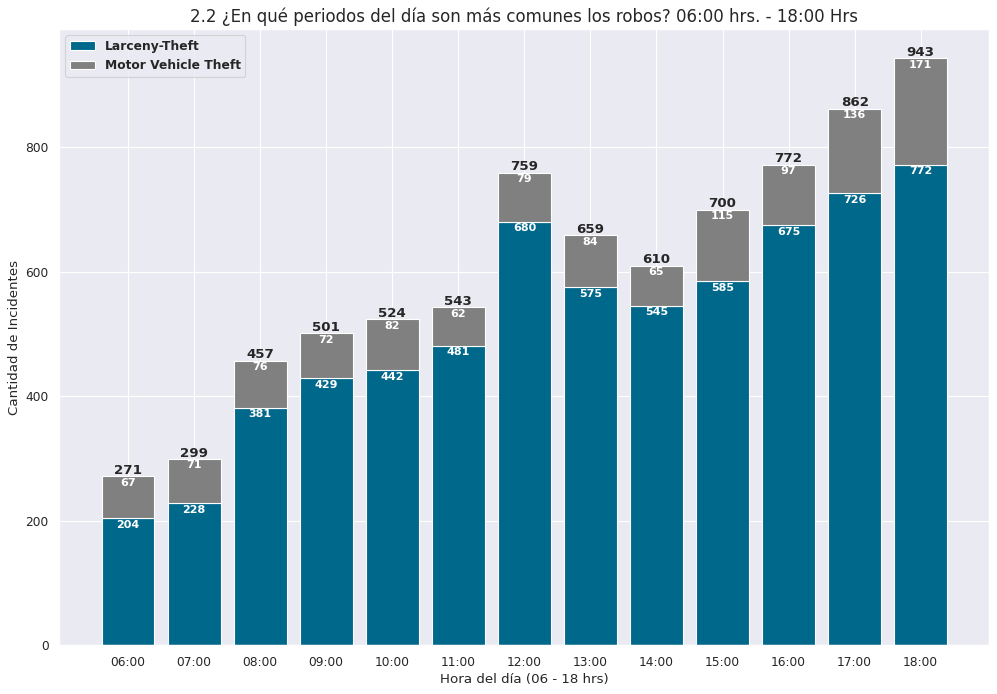

In [7]:
#2.1 ¿Qué incidentes son más comunes por la noche?
print('2.1 ¿Qué incidentes son más comunes por la noche?')

list1 =["night","early morning"]
by_night_zonehour=dfsea2014[(dfsea2014['ZoneHour'].isin(list1))]
by_night_zonehour = dfsea2014.groupby(['SeaStat Category ','SeaStat Offense'])['Offense Code'].count()


#by_night_zonehour. Ordenar resultado de forma ascendente por la columna cantidad total
by_night_zonehour=(by_night_zonehour.reset_index().sort_values(['Offense Code'],ascending=True).set_index(['SeaStat Category ','SeaStat Offense']))

#Genera grafico de barra horizontal
fig, ax = plt.subplots(figsize=(12,10), dpi=80)
by_night_zonehour.plot.barh(ax=ax, legend=True,rot=0,color='#00688B')
for rect in ax.patches:
    # Find where everything is located
    height = rect.get_height()
    width = rect.get_width()
    x = rect.get_x()
    y = rect.get_y()
    # The height of the bar is the data value and can be used as the label
    label_text = "{:,}".format(int(width)).replace(',','~').replace('.',',').replace('~','.')
    if width < 1000: label_x = x + width + 300
    else: label_x = x + width - 500
    
    label_y = y + ((height / 2)-0.05)
    # plot only when height is greater than specified value
    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center',fontsize=12,weight='bold')

#Setea titulo del grafico y eje X,Y.
ax.set_title('2.1 ¿Qué incidentes son más comunes por la noche? 19:00 hrs. - 06:00 hrs.',size=15)
ax.set_xlabel('Cantidad de Incidentes',size=12)
ax.set_ylabel('(SeaStat Category,SeaStat Offense)',size=12)
ax.legend(['Offense Code'],loc='lower right',fontsize=12,prop=legend_prop_bold)
ax.xaxis.set_major_formatter(FuncFormatter(formato_numerico))


#2.2 ¿En qué periodos del día son más comunes los robos?
print('2.2 ¿En qué periodos del día son más comunes los robos?')
list1 =["tomorrow","late"]
by_q2zonehour=dfsea2014[(dfsea2014['ZoneHour'].isin(list1)) & (dfsea2014['SeaStat Offense'].str.contains('Theft'))]
agg_tips = by_q2zonehour.groupby(['hour_starthhmm', 'SeaStat Offense'])['Offense Code'].count().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(15,10), dpi=80)

colors = ['#00688B', '#808080']
bottom = np.zeros(len(agg_tips))

for i, col in enumerate(agg_tips.columns):
    ax.bar(agg_tips.index, agg_tips[col], bottom=bottom, label=col, color=colors[i])
    bottom += np.array(agg_tips[col])

totals = agg_tips.sum(axis=1)
y_offset = 4
for i, total in enumerate(totals):
    ax.text(totals.index[i], total + y_offset, round(total), ha='center',
          weight='bold')

# Let's put the annotations inside the bars themselves by using a
# negative offset.
y_offset = -15
# For each patch (basically each rectangle within the bar), add a label.
for bar in ax.patches:
  ax.text(
      # Put the text in the middle of each bar. get_x returns the start
      # so we add half the width to get to the middle.
      bar.get_x() + bar.get_width() / 2,
      # Vertically, add the height of the bar to the start of the bar,
      # along with the offset.
      bar.get_height() + bar.get_y() + y_offset,
      # This is actual value we'll show.
      round(bar.get_height()),
      # Center the labels and style them a bit.
      ha='center',
      color='w',
      weight='bold',
      size=10
  )

ax.set_title('2.2 ¿En qué periodos del día son más comunes los robos? 06:00 hrs. - 18:00 Hrs',size=15)
ax.set_ylabel('Cantidad de Incidentes',size=12)
ax.set_xlabel('Hora del día (06 - 18 hrs)',size=12)
ax.legend(loc='best',fontsize=12,prop=legend_prop_bold)


In [9]:
#SEATTLE


########################################################################################
########################################################################################
########################################################################################
#3.1 Para cualquiera de las ciudades, ¿cómo varían los incidentes según el vecindario? 
print('3.1 Para cualquiera de las ciudades, ¿cómo varían los incidentes según el vecindario?')

#dfmcppid333=dfsea2014.groupby('MCPP').agg({"Report Number1": "count"}).rename(columns={"Report Number1": "count_incidents"})
#dfmcppid=dfsea2014.merge(dfsea2014mcpp1, left_on='MCPP', right_on='MCPP', how='right')

dfmcppid = dfsea2014.groupby(['MCPP']).agg({"Report Number1": "count"}).rename(columns={"Report Number1": "count_incidents"}).reset_index()

#Carga archivo GEOJSON obtenido desde sitio SEATTLE.GOV 
# Geojson
with open(os.path.join('Seattle_MCPP.geojson')) as f:
    geo_json = json.load(f)


center_pos = {} 
features = geo_json['features'] 
for feature in features: 
	k = feature['properties']['neighborhood'] 
	s = shape(feature["geometry"]) 
	p = s.centroid 
	center_pos[k] = list(p.coords)


fig = go.Figure() 
#Agrega en mapa por cada vecindario el número de incidentes.
for k,v in center_pos.items(): 
	#print(k,v) 
	val = dfmcppid[dfmcppid['MCPP'] == k]['count_incidents'] 
	try: 
		if float(format(val.values[0]))>1200: 
				colour='white'
		else: 
				colour='black'
		val = format(val.values[0]) #+'%'	
	except IndexError: 
		val = '{:1}'.format(1) 
	
	fig.add_trace(go.Scattermapbox( 
		lat=[center_pos[k][0][1]], 
		lon=[center_pos[k][0][0]], 
		mode='text', 
        textfont=dict( 
			color = colour, 
			size=12, 
		), 
		text=val, 
		showlegend=False
))

#Genera Mapa con MapBox con los vecindarios en Seattle y cantidad de incidentes.
fig.add_trace(go.Choroplethmapbox( 
	geojson=geo_json, 
	locations=dfmcppid['MCPP'], 
	featureidkey="properties.neighborhood", 
	z=dfmcppid['count_incidents'], 
    colorscale="Reds", 
    marker_opacity=0.7, 
	marker_line_width=1
)) 
fig.update_layout( 
#	mapbox_accesstoken=mapbox_access_token, 
    mapbox_style="carto-positron", 
	mapbox_zoom=9, 
	mapbox_center = {"lat": 47.60621, "lon": -122.33207} 
  
) 
fig.update_layout(autosize=False, 
    title_x=0.5
    ,title_y=0.95
    ,title_text="4. Para cualquiera de las ciudades, Incidentes segun vecindario verano 2014"
    ,margin={"l": 0, "r": 0, "b": 0, "t": 80}
    ,font_size=10
                 )
fig.show()


########################################################################################
########################################################################################
########################################################################################

3.1 Para cualquiera de las ciudades, ¿cómo varían los incidentes según el vecindario?


FileNotFoundError: [Errno 2] No such file or directory: 'Seattle_MCPP.geojson'